In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # instalado a parte - conda install -c conda-forge py-xgboost
from lightgbm import LGBMClassifier # instalado a parte - conda install -c conda-forge lightgbm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Parâmetros

In [3]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 16

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [4]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Kadabra/48e6960163b743eead89113f...,Kadabra
1,./PokemonData/Moltres/14b843831af548219fe66c16...,Moltres
2,./PokemonData/Venusaur/147437d570714abd81fc609...,Venusaur
3,./PokemonData/Chansey/3b7f979c0ad346a49aa66b19...,Chansey
4,./PokemonData/Jolteon/342e22c245ac445886577a67...,Jolteon
...,...,...
6820,./PokemonData/Gengar/cf6240a7c3e54a6b88a139e95...,Gengar
6821,./PokemonData/Aerodactyl/25adea61e7624a84a8fbe...,Aerodactyl
6822,./PokemonData/Venonat/c3139fc65541454395840875...,Venonat
6823,./PokemonData/Nidoqueen/ed0cd8fc30534f65822330...,Nidoqueen


## Analisando Dados

In [5]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


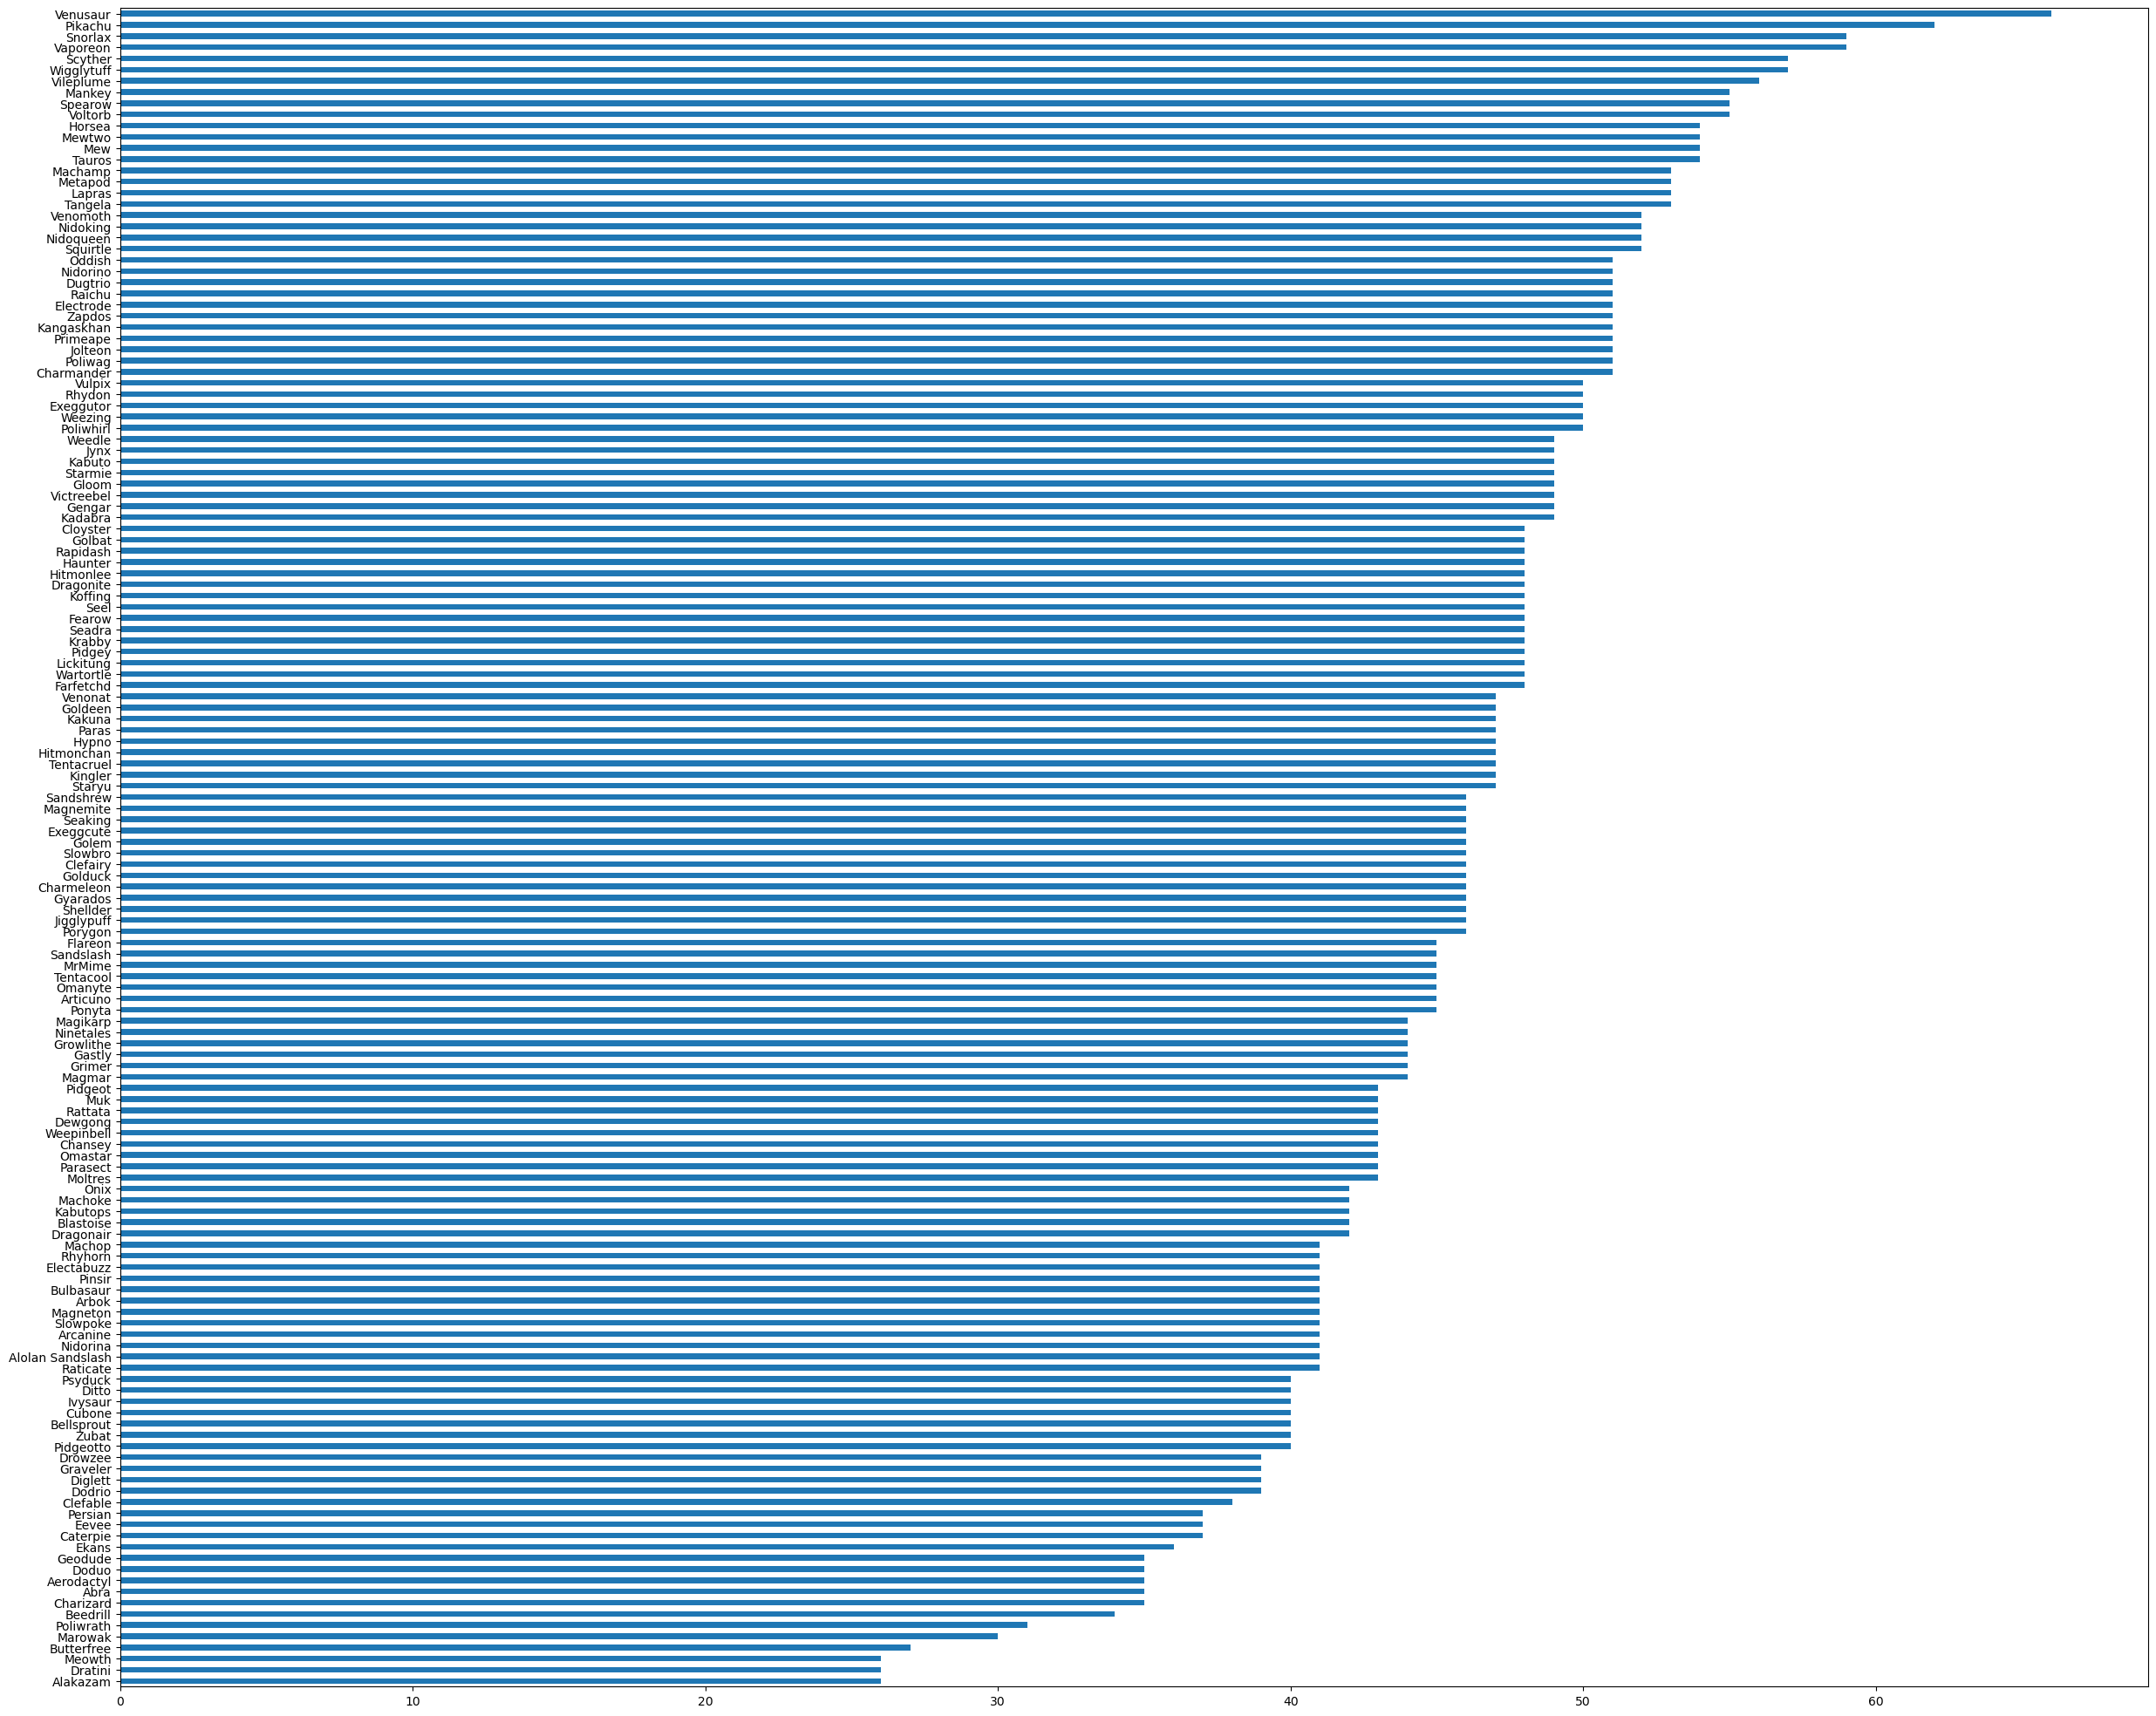

In [6]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [7]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

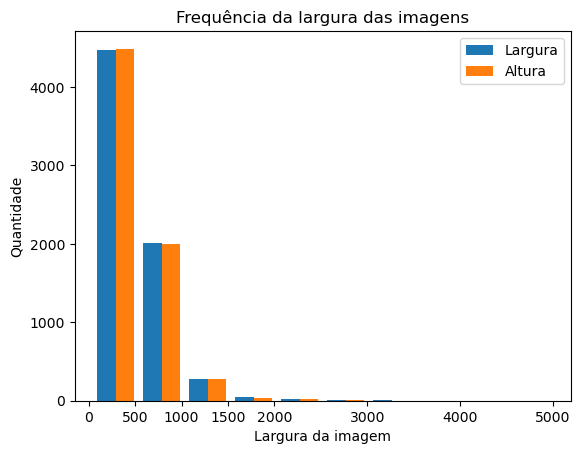

In [8]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [9]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [10]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [11]:
print(f"Tamanho da menor imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da menor imagem em relação a 
width: 43 
height: 42


In [12]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [13]:
# largura = math.floor(mean_width)
# altura = math.floor(mean_height)
largura = min(median_width, median_height)
altura = min(median_width, median_height)

## Preparando Dados

In [21]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    # return InceptionV3(weights='imagenet', include_top=False)
    return Xception(weights='imagenet', include_top=False)
    # return DenseNet201(weights='imagenet', include_top=False)
    # return MobileNetV3Small(weights='imagenet', include_top=False)
    # return VGG19(weights='imagenet', include_top=False)
    # return InceptionResNetV2(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingTest(embedder, img_path, largura, altura, modo_de_cor, n_transformations):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    
    array_img_transformed = []
    
    # FAZER NA IMAGEM ORINAL SEM MUDAR NADA
    img_transformed = image.img_to_array(img)

    embed = np.expand_dims(img_transformed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)
    
    array_img_transformed.append(features[0][0][0])
        
    for _ in range(n_transformations):
        
        img_transformed = data_images_generator.random_transform(image.img_to_array(img))

        embed = np.expand_dims(img_transformed, axis=0)
            # embed = preprocess_input(embed)

        features = embedder.predict(embed)
        
        array_img_transformed.append(features[0][0][0])

    return np.array(array_img_transformed)

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [ ]:
#tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [ ]:
target = df_dados['target'].array
n_transformations = 0

array_features = []
for x in dados:
    # array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    array_features.extend(embeddingTest(embedder, x[0], largura, altura, modo_de_cor, n_transformations))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

In [ ]:
target_transformation = np.repeat(target, n_transformations + 1) # imagens transformadas + a original

target_transformation

## Reduzindo a Dimensionalidade

In [ ]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target_transformation

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Mostrando só algumas classes da redução de dimensionalidade

In [ ]:
ten_classes = df_tsne['target'].unique()[0:10]

ten_classes

In [ ]:
df_tsne_filter_by_ten_classes = df_tsne[df_tsne['target'].isin(ten_classes)]

df_tsne_filter_by_ten_classes.head()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne_filter_by_ten_classes, x=df_tsne_filter_by_ten_classes[0], y=df_tsne_filter_by_ten_classes[1], hue=df_tsne_filter_by_ten_classes['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name} - Filtered by 10 Classes", bbox_inches="tight")

plt.show()

## Usando deep learning com transferlearning

In [ ]:
data_images_generator_train = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

data_images_generator_test = ImageDataGenerator(rescale=1./255)

In [ ]:
x_train_balanced, x_val_balanced, y_train_balanced, y_val_balanced = train_test_split(df_dados['image'], df_dados['target'], test_size=0.25, stratify=df_dados['target'])


In [ ]:
print(f'{len(x_train_balanced)} + {len(x_val_balanced)} = {len(x_train_balanced) + len(x_val_balanced)}')

In [ ]:
print(f'{len(y_train_balanced)} + {len(y_val_balanced)} = {len(y_train_balanced) + len(y_val_balanced)}')

In [ ]:
df_dados_train = pd.DataFrame({'image': x_train_balanced, 'target': y_train_balanced})

df_dados_train

In [ ]:
df_dados_test= pd.DataFrame({'image': x_val_balanced, 'target': y_val_balanced})

df_dados_test

In [ ]:
data_gen_train = data_images_generator_train.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_train,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

data_gen_test= data_images_generator_test.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_test,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=False,
                                                     target_size=(largura,altura))


In [ ]:
images = [data_gen_train[0][0][8] for i in range(5)]
plotImages(images)

In [ ]:
images = [data_gen_test[0][0][8] for i in range(5)]
plotImages(images)

In [ ]:
conv_base = keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, #.Xception(weights='imagenet', include_top=False,
                  input_shape=(largura,altura,3))
conv_base.trainable = False

In [ ]:
my_init = keras.initializers.glorot_uniform(seed = 1)
model = keras.models.Sequential([
    conv_base,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1024, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(512, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),

    keras.layers.Dense(150, activation='softmax', kernel_initializer = my_init)
                         
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [ ]:
model.summary()

In [ ]:
EPOCHS = 20

In [ ]:
callbacks = [
    ModelCheckpoint("PokemonClassification.h5", save_best_only=True),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=5), ## interrompe se nao houver melhora apos um numero de epocas definidas
    ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=3) ## nao melhora apos um numero de epocas definidas
]

In [ ]:
len(data_gen_train) * 16

In [ ]:
history = model.fit(
            data_gen_train,
            #steps_per_epoch=math.ceil(len(data_gen_train) / BATCH_SIZE),
            epochs=EPOCHS,
            validation_data=data_gen_test,
           # validation_steps=math.ceil(len(data_gen_test) / BATCH_SIZE),
            callbacks=callbacks
          )

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

In [ ]:
epochs_range = range(EPOCHS)

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')

plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')

plt.show()